<a href="https://colab.research.google.com/gist/terris-citizen/2621785fc36ece9757c812d3047d5370/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Please do not share this notebook outside Citizen Health

# Install Dependencies

In [60]:
!pip install PyGithub pandas matplotlib ace-tools-open pytz tabulate

# Git Config

Do not share this notebook outside Citizen Health!

In [61]:
GITHUB_TOKEN = "H"
# Comma-delimited list
REPO_NAMES = "Ciitizen/apps-monorepo"

# Specify How Much PR History to Process

In [62]:
# 30 days of data takes about 5 minutes
max_days = 45
per_page = 50  # Max per request
max_pages = 500 # Prevent infinite loop

In [63]:
# Calculate the cutoff date
from datetime import datetime, timedelta
import pytz

cutoff_date = datetime.now(pytz.UTC) - timedelta(days=max_days)

print (f"Processing {REPO_NAMES} for PRs after {cutoff_date}")

Processing Ciitizen/apps-monorepo for PRs after 2025-01-09 17:56:13.738971+00:00


# Function: If a PR is opened after 12 PM PST on a Friday, use Monday 6 AM PST as the PR creation date

In [64]:
# If a PR is opened after 12 PM PST on a Friday, use Monday 6 AM PST as the PR creation date
def adjust_weekend_date(dt):
    """
    Adjusts dates that fall on weekends to the following Monday 6 AM PST.

    Args:
        dt (datetime): Input datetime (should be timezone-aware)

    Returns:
        datetime: Either the original datetime or adjusted to following Monday 6 AM PST
    """
    # Ensure we're working with PST timezone
    pst_tz = pytz.timezone('America/Los_Angeles')
    if dt.tzinfo is None:
        dt = pst_tz.localize(dt)
    else:
        dt = dt.astimezone(pst_tz)

    # Get the day of week (0 = Monday, 6 = Sunday)
    weekday = dt.weekday()

    # Create timestamp for the current day at 12 PM PST
    noon_time = dt.replace(hour=12, minute=0, second=0, microsecond=0)

    # Check if we're in the weekend window
    is_weekend = False

    if weekday == 4:  # Friday
        is_weekend = dt >= noon_time
    elif weekday == 5 or weekday == 6:  # Saturday or Sunday
        is_weekend = True
    elif weekday == 0:  # Monday
        morning_time = dt.replace(hour=6, minute=0, second=0, microsecond=0)
        is_weekend = dt < morning_time

    if is_weekend:
        # Calculate next Monday
        days_until_monday = (7 - weekday) % 7
        if weekday == 0:  # If Monday but before 6 AM
            days_until_monday = 0

        next_monday = dt + timedelta(days=days_until_monday)
        return next_monday.replace(hour=6, minute=0, second=0, microsecond=0)

    return dt

In [65]:
def test_adjust_weekend_date():
    # Create timezone-aware test cases using explicit construction
    pst_tz = pytz.timezone('America/Los_Angeles')

    def create_pst_datetime(year, month, day, hour, minute):
        # Helper function to create timezone-aware datetime in PST
        naive_dt = datetime(year, month, day, hour, minute)
        return pst_tz.localize(naive_dt)

    test_cases = [
        # Friday before noon (should not change)
        (
            create_pst_datetime(2025, 2, 21, 11, 0),
            create_pst_datetime(2025, 2, 21, 11, 0)
        ),

        # Friday after noon (should go to Monday 6 AM)
        (
            create_pst_datetime(2025, 2, 21, 13, 0),
            create_pst_datetime(2025, 2, 24, 6, 0)
        ),

        # Saturday (should go to Monday 6 AM)
        (
            create_pst_datetime(2025, 2, 22, 10, 0),
            create_pst_datetime(2025, 2, 24, 6, 0)
        ),

        # Monday 5:59 AM (should go to Monday 6 AM)
        (
            create_pst_datetime(2025, 2, 24, 5, 59),
            create_pst_datetime(2025, 2, 24, 6, 0)
        ),

        # Monday 6 AM (should not change)
        (
            create_pst_datetime(2025, 2, 24, 6, 0),
            create_pst_datetime(2025, 2, 24, 6, 0)
        ),

        # Cross-month test: Friday May 30, 2025 2 PM PST to Monday June 2, 2025 6 AM PST
        (
            create_pst_datetime(2025, 5, 30, 14, 0),
            create_pst_datetime(2025, 6, 2, 6, 0)
        ),
    ]

    for input_dt, expected_dt in test_cases:
        result = adjust_weekend_date(input_dt)
        assert result == expected_dt, (
            f"Failed: Input: {input_dt}, Expected: {expected_dt}, Got: {result}\n"
            f"Input TZ: {input_dt.tzinfo}, Result TZ: {result.tzinfo}"
        )

    print("All tests passed!")

# Function: Download PRs

In [66]:
processed_all_prs = True

def get_prs(repo):
    page = 0  # Start at the first page
    processed_all_for_repo = False
    repo_prs = []

    while page < max_pages:
        prs = repo.get_pulls(
            sort="created",
            direction="desc",
            state="all"
        )[page * per_page : (page + 1) * per_page]  # Manual pagination

        # Filter PRs by created_at date
        filtered_prs = [pr for pr in prs if pr.created_at >= cutoff_date]

        if not filtered_prs:
            processed_all_for_repo = True
            break  # No more PRs in the date range, exit loop

        repo_prs.extend(filtered_prs)
        page += 1  # Move to next page

    if not processed_all_for_repo:
        print(f"Loop terminated early due to max_pages ({max_pages}) failsafe")
        processed_all_prs = False

    return repo_prs

# Function: Process PR Reviews

In [67]:
pr_data = []

def get_pr_data(repo, prs):
    for pr in prs:
        # If the pr is a draft skip it
        if pr.draft:
            print(f"#{pr.number} is a draft")
            continue

        reviews = pr.get_reviews()
        # remove reviews by the author
        reviews = [
            review for review in reviews
            if review.user.login != pr.user.login and
                review.user.login != "coderabbitai[bot]"
        ]

        if len(reviews) == 0:
            print(f"No reviews for #{pr.number} by {pr.user.login}")
            continue

        # When was the PR ready for review?
        issue = repo.get_issue(pr.number)
        timeline = issue.get_timeline()
        ready_for_review_times = []
        ready_for_review_at = pr.created_at

        for event in timeline:
            if event.event == "ready_for_review":
                ready_for_review_at = event.created_at
                ready_for_review_times.append(ready_for_review_at)
                # Continue the loop. Use the last ready for review event

        # When was the first review submitted after the PR was ready for review?
        for review in reviews:
            if review.submitted_at >= ready_for_review_at:
                first_review_at = review.submitted_at
                break

        if first_review_at is None:
            if len(ready_for_review_times) > 0:
                print(f"No review for #{pr.number} by {pr.user.login} is after the last ready for review event {ready_for_review_times}")
            first_review_at = reviews[0].submitted_at

        if pr.merged_at is None:
            time_to_merge = None
        else:
            time_to_merge = (pr.merged_at - adjust_weekend_date(pr.created_at)).total_seconds() / 3600
            if time_to_merge < 0:
                time_to_merge = (pr.merged_at - pr.created_at).total_seconds() / 3600

        time_to_first_review = (adjust_weekend_date(first_review_at) - ready_for_review_at).total_seconds() / 3600
        if time_to_first_review < 0:
            time_to_first_review = (first_review_at - ready_for_review_at).total_seconds() / 3600

        # print(reviews)

        pr_data.append({
            "PR Number": pr.number,
            "Author": pr.user.login,
            "Created At": pr.created_at,
            "Ready For Review At": ready_for_review_at,
            "Time to First Review (hrs)": time_to_first_review,
            "Merged At": pr.merged_at,
            "Time to Merge (hrs)": time_to_merge,
            "Number of Reviews": len(reviews),
        })

# Download Data

In [68]:
from github import Github
g = Github(GITHUB_TOKEN)

In [69]:
for repo_name in REPO_NAMES.split(','):
    repo_name2 = repo_name.strip()
    repo = g.get_repo(repo_name2)
    print (f"Collecting PRs for {repo_name2}")
    prs = get_prs(repo)
    print (f"Processing PRs for {repo_name2}")
    get_pr_data(repo, prs)

Processing PRs for Ciitizen/apps-monorepo
No reviews for #2474 by rarchilach
No reviews for #2473 by jingyufanclub
No reviews for #2472 by jingyufanclub
No reviews for #2434 by terris-citizen
#2433 is a draft
#2432 is a draft
No reviews for #2405 by dependabot[bot]
No reviews for #2404 by dependabot[bot]
#2382 is a draft
#2359 is a draft
#2277 is a draft
#2264 is a draft
#2263 is a draft
#2258 is a draft


# Begin Analysis

In [70]:
import pandas as pd

num_prs = len(pr_data)
min_created_at = min(pr["Created At"] for pr in pr_data)
max_created_at = max(pr["Created At"] for pr in pr_data)
min_merged_at = min((pr["Merged At"] for pr in pr_data if pr["Merged At"] is not None), default=None)
max_merged_at = max((pr["Merged At"] for pr in pr_data if pr["Merged At"] is not None), default=None)
# Compute the average number of reviews per PR
avg_num_reviews = sum(pr["Number of Reviews"]) / num_prs

# Create a summary DataFrame
summary_df = pd.DataFrame({
    "Metric": ["Processed All PRs", "Number of PRs", "Min Created At", "Max Created At", "Min Merged At", "Max Merged At", "Avg Number of Reviews per PR"],
    "Value": [processed_all_prs, num_prs, min_created_at, max_created_at, min_merged_at, max_merged_at, avg_num_reviews]
})

# Display the summary table
summary_df

,Metric,Value
0,Processed All PRs,True
1,Number of PRs,213
2,Min Created At,2025-01-09 19:34:26+00:00
3,Max Created At,2025-02-21 20:44:35+00:00
4,Min Merged At,2025-01-09 19:45:50+00:00
5,Max Merged At,2025-02-22 01:59:32+00:00
6,Avg Number of Reviews per PR,1.868545


In [71]:
df = pd.DataFrame(pr_data)

PRs


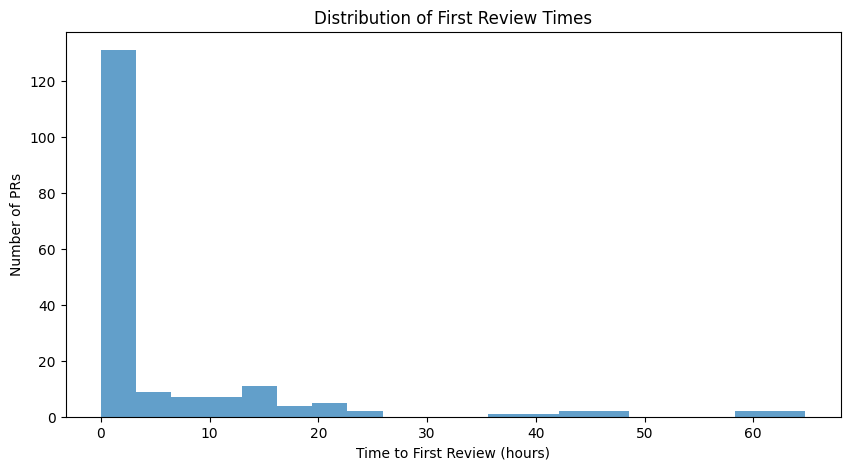

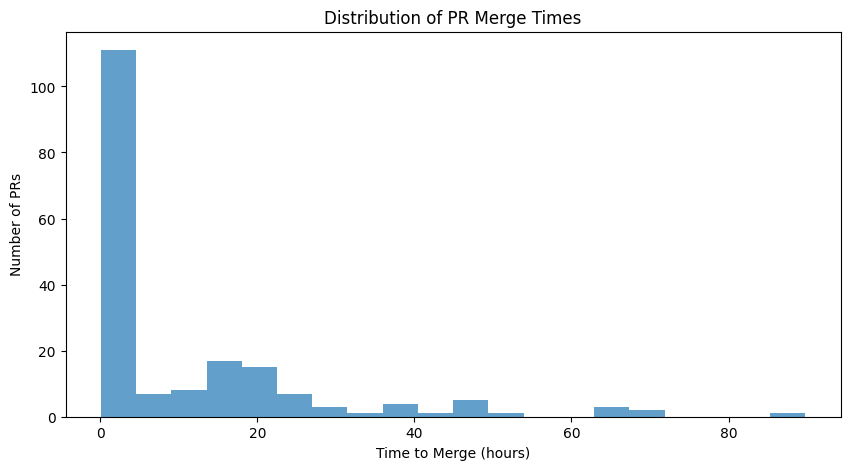

In [72]:
# Display charts
import ace_tools_open as tools
import matplotlib.pyplot as plt

# Remove outliers for better visualization
df_filtered = df[pd.notna(df["Time to Merge (hrs)"])].query('`Time to Merge (hrs)` < `Time to Merge (hrs)`.quantile(0.95)')
df_filtered = df_filtered[df_filtered["Time to First Review (hrs)"] < df_filtered["Time to First Review (hrs)"].quantile(0.95)]

tools.display_dataframe_to_user(name="PRs", dataframe=df)

# Plot histograms
plt.figure(figsize=(10, 5))
plt.hist(df_filtered["Time to First Review (hrs)"].dropna(), bins=20, alpha=0.7)
plt.xlabel("Time to First Review (hours)")
plt.ylabel("Number of PRs")
plt.title("Distribution of First Review Times")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(df_filtered["Time to Merge (hrs)"].dropna(), bins=20, alpha=0.7)
plt.xlabel("Time to Merge (hours)")
plt.ylabel("Number of PRs")
plt.title("Distribution of PR Merge Times")
plt.show()

In [73]:
# time range analysis
def analyze_time_ranges(series, metric_name):
    total = len(series.dropna())

    # Calculate counts and percentages for each range
    ranges = {
        "< 1 day": (series <= 24).sum(),
        "1-2 days": ((series > 24) & (series <= 48)).sum(),
        "2-3 days": ((series > 48) & (series <= 72)).sum(),
        "3-4 days": ((series > 72) & (series <= 96)).sum(),
        "> 4 days": (series > 96).sum()
    }

    # Convert to percentages
    percentages = {k: (v/total * 100) for k, v in ranges.items()}

    print(f"\n{metric_name} Analysis:")
    print("-" * 50)
    for range_name, count in ranges.items():
        print(f"{range_name}: {count} PRs ({percentages[range_name]:.1f}%)")

# Analyze both metrics
analyze_time_ranges(df["Time to First Review (hrs)"], "Time to First Review")
analyze_time_ranges(df["Time to Merge (hrs)"], "Time to Merge")


Time to First Review Analysis:
--------------------------------------------------
< 1 day: 181 PRs (85.0%)
1-2 days: 9 PRs (4.2%)
2-3 days: 14 PRs (6.6%)
3-4 days: 5 PRs (2.3%)
> 4 days: 4 PRs (1.9%)

Time to Merge Analysis:
--------------------------------------------------
< 1 day: 167 PRs (80.7%)
1-2 days: 18 PRs (8.7%)
2-3 days: 10 PRs (4.8%)
3-4 days: 2 PRs (1.0%)
> 4 days: 10 PRs (4.8%)


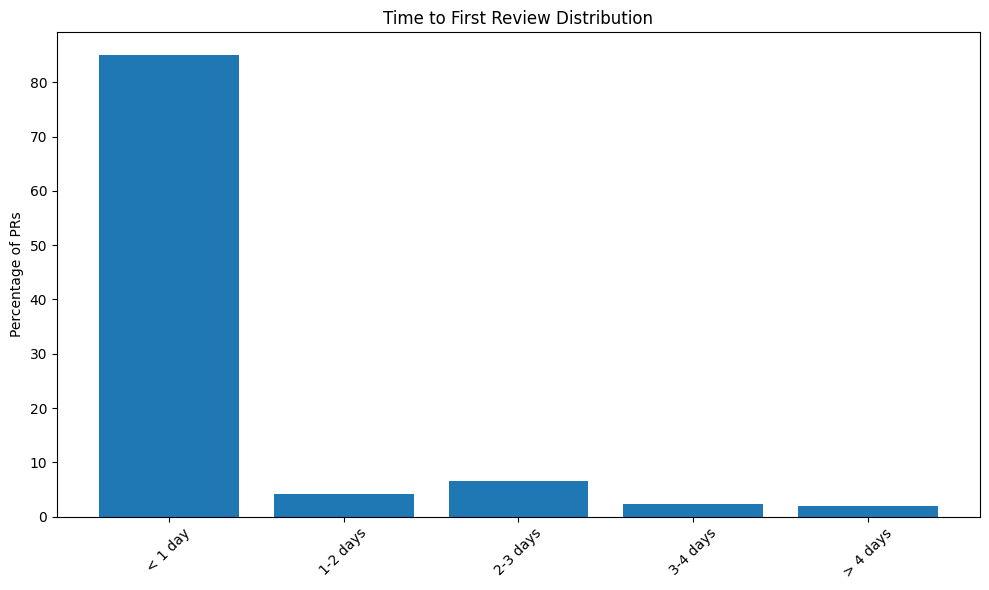

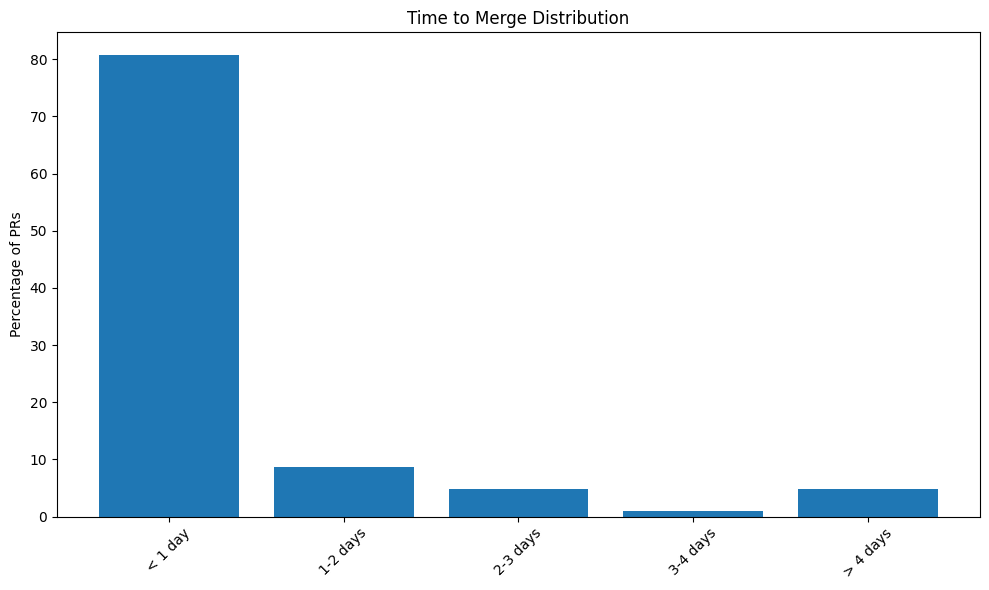

In [74]:
# Time to first review and merge distribution charts
def plot_time_ranges(df, metric_col, title):
    total = len(df[metric_col].dropna())

    ranges = {
        "< 1 day": (df[metric_col] <= 24).sum() / total * 100,
        "1-2 days": ((df[metric_col] > 24) & (df[metric_col] <= 48)).sum() / total * 100,
        "2-3 days": ((df[metric_col] > 48) & (df[metric_col] <= 72)).sum() / total * 100,
        "3-4 days": ((df[metric_col] > 72) & (df[metric_col] <= 96)).sum() / total * 100,
        "> 4 days": (df[metric_col] > 96).sum() / total * 100
    }

    plt.figure(figsize=(10, 6))
    plt.bar(ranges.keys(), ranges.values())
    plt.title(title)
    plt.ylabel("Percentage of PRs")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot both metrics
plot_time_ranges(df, "Time to First Review (hrs)", "Time to First Review Distribution")
plot_time_ranges(df, "Time to Merge (hrs)", "Time to Merge Distribution")

In [75]:
authors = (df.groupby('Author')
            .size()
            .reset_index(name='Number of PRs')
            .sort_values('Number of PRs', ascending=False))

print("All PRs")
print(authors)

All PRs
                    Author  Number of PRs
0                GonzaGr92             42
2            carolinaspina             32
10                pnieloud             27
7                 marticks             17
5            jingyufanclub             16
12                slee4343             15
13          terris-citizen             15
1   brian-mcdonell-invitae             11
4              facarrizo24             11
14                zvik2004             11
11              rarchilach             10
3                   ddwang              2
9        phmurias-ciitizen              2
6     juanfeldman-ciitizen              1
8              mcrasso-cii              1


In [76]:
authors = (df[df['Merged At'].notna()]  # Filter out rows where Merged At is None
            .groupby('Author')
            .size()
            .reset_index(name='Number of PRs')
            .sort_values('Number of PRs', ascending=False))

print("\nMerged PRs")
print(authors)


Merged PRs
                    Author  Number of PRs
0                GonzaGr92             42
2            carolinaspina             32
10                pnieloud             26
5            jingyufanclub             16
7                 marticks             16
12                slee4343             15
13          terris-citizen             13
1   brian-mcdonell-invitae             11
14                zvik2004             11
4              facarrizo24             10
11              rarchilach             10
9        phmurias-ciitizen              2
3                   ddwang              1
6     juanfeldman-ciitizen              1
8              mcrasso-cii              1


In [77]:
# Calculate metrics for time to first review by author
review_stats = df.groupby('Author').agg({
    'Time to First Review (hrs)': ['mean', 'median', 'max']
}).sort_values(('Time to First Review (hrs)', 'mean'), ascending=False).head(5)

# Calculate metrics for time to merge by author
merge_stats = df.groupby('Author').agg({
    'Time to Merge (hrs)': ['mean', 'median', 'max']
}).sort_values(('Time to Merge (hrs)', 'mean'), ascending=False).head(5)

# Format the tables
review_stats.columns = ['Avg Time to First Review (hrs)', 'Median Time to First Review (hrs)', 'Max Time to First Review (hrs)']
merge_stats.columns = ['Avg Time to Merge (hrs)', 'Median Time to Merge (hrs)', 'Max Time to Merge (hrs)']

print("Top 5 Authors by Avg Time to First Review:")
print("-" * 60)
print(review_stats.round(2))

print("\nTop 5 Authors by Avg Time to Merge:")
print("-" * 60)
print(merge_stats.round(2))

Top 5 Authors by Avg Time to First Review:
------------------------------------------------------------
                   Avg Time to First Review (hrs)  \
Author                                              
phmurias-ciitizen                           93.94   
terris-citizen                              33.49   
slee4343                                    22.85   
jingyufanclub                               20.12   
GonzaGr92                                   15.97   

                   Median Time to First Review (hrs)  \
Author                                                 
phmurias-ciitizen                              93.94   
terris-citizen                                 24.47   
slee4343                                        3.00   
jingyufanclub                                   6.95   
GonzaGr92                                       0.90   

                   Max Time to First Review (hrs)  
Author                                             
phmurias-ciitizen          

In [78]:
review_stats = df.groupby('Author').agg({
    'Time to First Review (hrs)': ['mean', 'median', 'max']
}).sort_values(('Time to First Review (hrs)', 'median'), ascending=False).head(5)

# Calculate metrics for time to merge by author
merge_stats = df.groupby('Author').agg({
    'Time to Merge (hrs)': ['mean', 'median', 'max']
}).sort_values(('Time to Merge (hrs)', 'median'), ascending=False).head(5)

# Format the tables
review_stats.columns = ['Avg Time to First Review (hrs)', 'Median Time to First Review (hrs)', 'Max Time to First Review (hrs)']
merge_stats.columns = ['Avg Time to Merge (hrs)', 'Median Time to Merge (hrs)', 'Max Time to Merge (hrs)']

print("Top 5 Authors by Median Time to First Review:")
print("-" * 60)
print(review_stats.round(2))

print("\nTop 5 Authors by Median Time to Merge:")
print("-" * 60)
print(merge_stats.round(2))

Top 5 Authors by Median Time to First Review:
------------------------------------------------------------
                   Avg Time to First Review (hrs)  \
Author                                              
phmurias-ciitizen                           93.94   
terris-citizen                              33.49   
jingyufanclub                               20.12   
rarchilach                                   6.36   
mcrasso-cii                                  3.75   

                   Median Time to First Review (hrs)  \
Author                                                 
phmurias-ciitizen                              93.94   
terris-citizen                                 24.47   
jingyufanclub                                   6.95   
rarchilach                                      5.32   
mcrasso-cii                                     3.75   

                   Max Time to First Review (hrs)  
Author                                             
phmurias-ciitizen       

In [79]:
review_stats = df.groupby('Author').agg({
    'Time to First Review (hrs)': ['mean', 'median', 'max']
}).sort_values(('Time to First Review (hrs)', 'max'), ascending=False).head(5)

# Calculate metrics for time to merge by author
merge_stats = df.groupby('Author').agg({
    'Time to Merge (hrs)': ['mean', 'median', 'max']
}).sort_values(('Time to Merge (hrs)', 'max'), ascending=False).head(5)

# Format the tables
review_stats.columns = ['Avg Time to First Review (hrs)', 'Median Time to First Review (hrs)', 'Max Time to First Review (hrs)']
merge_stats.columns = ['Avg Time to Merge (hrs)', 'Median Time to Merge (hrs)', 'Max Time to Merge (hrs)']

print("Top 5 Authors by Max Time to First Review:")
print("-" * 60)
print(review_stats.round(2))

print("\nTop 5 Authors by Max Time to Merge:")
print("-" * 60)
print(merge_stats.round(2))

Top 5 Authors by Max Time to First Review:
------------------------------------------------------------
                   Avg Time to First Review (hrs)  \
Author                                              
GonzaGr92                                   15.97   
slee4343                                    22.85   
jingyufanclub                               20.12   
phmurias-ciitizen                           93.94   
terris-citizen                              33.49   

                   Median Time to First Review (hrs)  \
Author                                                 
GonzaGr92                                       0.90   
slee4343                                        3.00   
jingyufanclub                                   6.95   
phmurias-ciitizen                              93.94   
terris-citizen                                 24.47   

                   Max Time to First Review (hrs)  
Author                                             
GonzaGr92                  